IMPORTING ALL NECESSARY PACKAGES. MOST OF THEM ARE ALREADY IN THE ANACONDA DISTRIBUTION

In [1]:
import asyncio
import nest_asyncio
import aiohttp
from understat import Understat
import codecs
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.animation as animation
#import torch
import subprocess
import os
from highlight_text import ax_text,fig_text
from mplsoccer import (VerticalPitch)
from PIL import Image, ImageFilter, ImageEnhance
from mplsoccer import add_image
from matplotlib.animation import FFMpegWriter

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
club="Borussia Dortmund"  # CHANGE CLUB NAME HERE

In [4]:
with open('club_name.txt', 'w') as f:
    f.write(club)
    f.close

In [5]:
team_for_foto=""
if club == "RasenBallsport Leipzig":
    team_for_foto="RB Leipzig"
elif club == "FC Cologne":
    team_for_foto="FC Köln"
elif club== "Augsburg":
    team_for_foto="FC Augsburg"
elif club== "Borussia M.Gladbach":
    team_for_foto="Borussia Mönchengladbach"
else:
    team_for_foto=club
team_for_foto

'Borussia Dortmund'

In [6]:
torneo="2025-2026"

In [7]:
foto_path=f'images/{team_for_foto}.png'

In [8]:
%run -i undesstatteams.py

Borussia Dortmund
[
    {
        "id": "30230",
        "isResult": true,
        "side": "a",
        "h": {
            "id": "288",
            "title": "St. Pauli",
            "short_title": "SPA"
        },
        "a": {
            "id": "129",
            "title": "Borussia Dortmund",
            "short_title": "DOR"
        },
        "goals": {
            "h": "3",
            "a": "3"
        },
        "xG": {
            "h": "1.46772",
            "a": "2.10289"
        },
        "datetime": "2025-08-23 16:30:00",
        "forecast": {
            "w": 0.2676940231295394,
            "d": 0.2100132816889559,
            "l": 0.5222926876539226
        },
        "result": "d"
    },
    {
        "id": "30240",
        "isResult": true,
        "side": "h",
        "h": {
            "id": "129",
            "title": "Borussia Dortmund",
            "short_title": "DOR"
        },
        "a": {
            "id": "240",
            "title": "Union Berlin",
           

In [9]:
# Get csv from D://understatteams.py !!!!!
df_understat=pd.read_csv(f'{club}_seasons_shots.csv')

In [10]:
df_understat.head()

,minute,X,Y,player,shotType,result,h_team,a_team,player_assisted,xG
0,23,0.901,0.268,Serhou Guirassy,RightFoot,SavedShot,St. Pauli,Borussia Dortmund,Pascal Groß,0.064968
1,24,0.970,0.406,Pascal Groß,RightFoot,SavedShot,St. Pauli,Borussia Dortmund,Karim Adeyemi,0.436790
2,33,0.929,0.462,Serhou Guirassy,Head,Goal,St. Pauli,Borussia Dortmund,Marcel Sabitzer,0.455366
3,38,0.885,0.500,Serhou Guirassy,RightFoot,SavedShot,St. Pauli,Borussia Dortmund,NaN,0.757777
4,46,0.798,0.603,Julian Brandt,LeftFoot,SavedShot,St. Pauli,Borussia Dortmund,Daniel Svensson,0.040902


In [11]:
own_goals_total=len(df_understat[df_understat['result']=='OwnGoal'])
own_goals_total

0

In [12]:
own_goals=df_understat[df_understat['result']=='OwnGoal']
own_goals['xG']=0.5
own_goals

,minute,X,Y,player,shotType,result,h_team,a_team,player_assisted,xG


In [13]:
async def main():
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        players = await understat.get_league_players(
            "bundesliga",
            2025,
            team_title=club
        )
        squad=json.dumps(players, indent=4, ensure_ascii=False)
    with codecs.open(f'{club}_squad.json', "w", "utf-8") as jsonfile:
        jsonfile.write(squad)
        #json.dumps(jamal_json, indent=4)
        jsonfile.close() 

nest_asyncio.apply()
loop = asyncio.get_event_loop()
loop.run_until_complete(main())

squad_df=pd.read_json(f'{club}_squad.json')

In [14]:
squad=squad_df['player_name'].unique()
squad

array(['Serhou Guirassy', 'Julian Brandt', 'Maximilian Beier',
       'Karim Adeyemi', 'Waldemar Anton', 'Emre Can', 'Ramy Bensebaini',
       'Nico Schlotterbeck', 'Felix Nmecha', 'Carney Chukwuemeka',
       'Yan Couto', 'Daniel Svensson', 'Aaron Anselmino', 'Niklas Süle',
       'Pascal Groß', 'Marcel Sabitzer', 'Gregor Kobel', 'Salih Özcan',
       'Julian Ryerson', 'Fabio Silva', 'Filippo Mané', 'Cole Campbell',
       'Jobe Bellingham'], dtype=object)

In [15]:
"Paul Nebel" in squad

False

In [16]:
own_goals_len=len(own_goals[~own_goals['player'].isin(squad)])
own_goals_len

0

In [17]:
ogf=own_goals[~own_goals['player'].isin(squad)]
ogf

,minute,X,Y,player,shotType,result,h_team,a_team,player_assisted,xG


In [18]:
own_goals_for=0
for player in own_goals['player']:
    if player not in squad:
        own_goals_for+=1
own_goals_for

0

In [19]:
# THE X AND Y LABELS ARE SCALED BETWEEN 0 and 1. SINCE WE WILL BE USING OPTA AXES WHICH GO FROM 100 to 100, WE NEED TO
# SCALE BOTH THESE UPTO 100

df_understat['X'] = df_understat['X'].apply(lambda x:x*100)
df_understat['Y'] = df_understat['Y'].apply(lambda x:x*100)

#df_understat['result'].unique()

In [20]:
df_understat[df_understat['result']=='OwnGoal']

,minute,X,Y,player,shotType,result,h_team,a_team,player_assisted,xG


In [21]:
#pip install mplsoccer
#pip install highlight-text

WE WILL CHANGE SOME OF THE BASIC PARAMETERS USING THE rcParams method OF MPL

In [22]:
background = '#D6DBD9'
text_color = 'black'
mpl.rcParams['xtick.color']=text_color
mpl.rcParams['ytick.color']=text_color
mpl.rcParams['text.color']=text_color
mpl.rcParams['font.family']='sans-serif'
mpl.rcParams['font.sans-serif']='Franklin Gothic Medium Cond'
mpl.rcParams['legend.fontsize'] = 12


In [23]:
#mpl.font_manager.FontManager.get_font_names(mpl)
ogf

,minute,X,Y,player,shotType,result,h_team,a_team,player_assisted,xG


In [24]:
#if torch.cuda.is_available():
 #   device = torch.device("cuda")
#else:
 #   device = torch.device("cpu")
    
#print("using", device, "device")

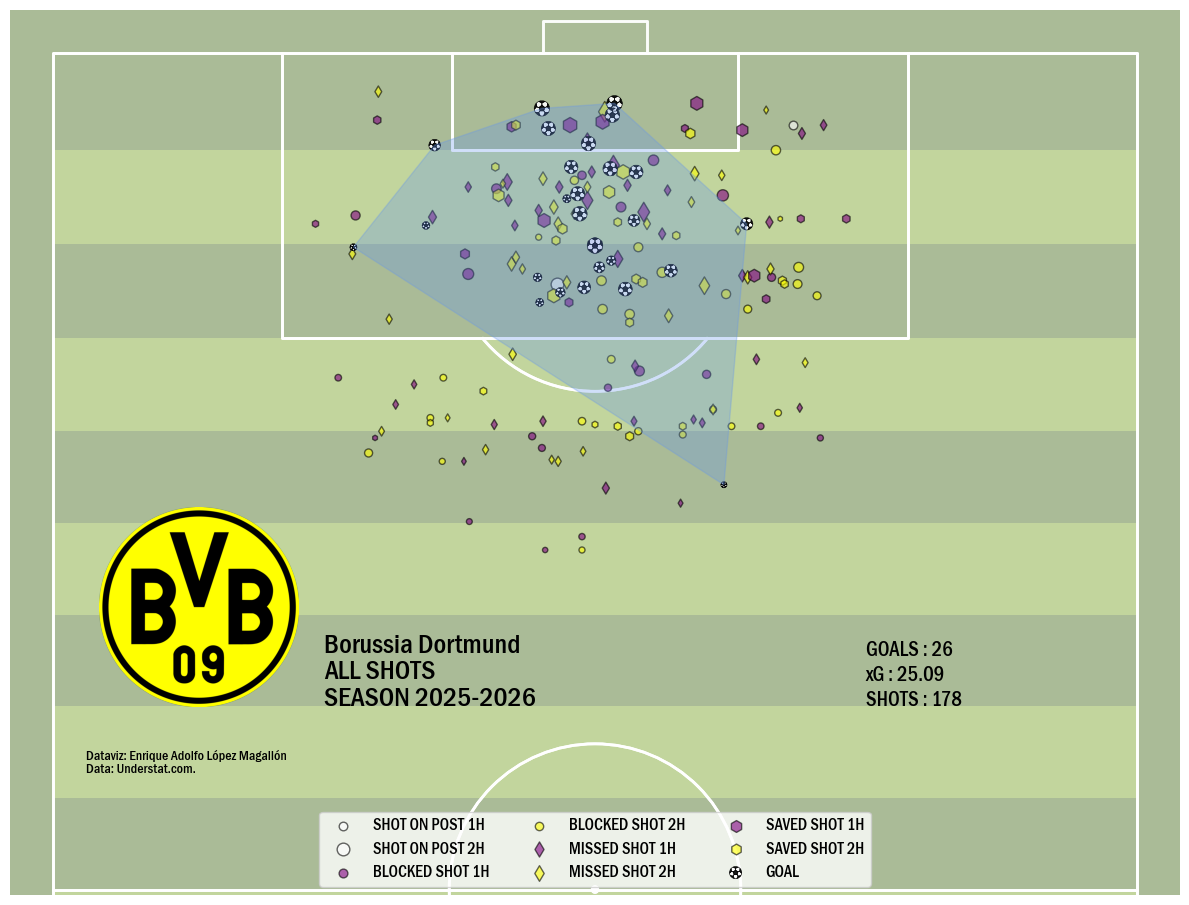

In [25]:
# SETTING UP THE AXES
#fig, ax = plt.subplots(figsize=(10,12))
#ax.axis('off')
#fig.set_facecolor(background)

#SETTING UP THE MPL AXIS FOR THE FIRST TEAM
pitch = pitch = VerticalPitch(pad_bottom=0.5,  # pitch extends slightly below halfway line 
    half=True,  # half of a pitch
    goal_type='box',
    goal_alpha=0.8, 
    pitch_type='opta',
    pitch_color='#aabb97',
    stripe=True,
    stripe_color='#c2d59d',
    line_color='white')  

fig, ax = pitch.draw(figsize=(12, 10))

#PLOTTING HTEAM
#df_fil = df_understat.loc[df_understat['HomeAway']=='h']
df_fil = df_understat
#df_hOG = df_fil[df_fil['HomeAway']=='a']
#df_fil = df_a
#df_hOG = df_fil[df_fil['HomeAway']=='h']
df_h1H = df_fil[df_fil['minute']<=45]
df_h2H = df_fil[df_fil['minute']>45]

#PLOTTING SHOTS TEAM 1 PER TYPE AND HALF.LABELS APPEAR ONLY IF VARIABLE IS FILLED


if "ShotOnPost" in iter(df_h1H['result']):
    pitch.scatter(df_h1H[df_h1H['result']=='ShotOnPost']['X'],df_h1H[df_h1H['result']=='ShotOnPost']['Y'], 
              s=np.sqrt(df_h1H[df_h1H['result']=='ShotOnPost']['xG'])*150, marker='o', alpha=0.6,
              edgecolors='black', facecolor='white', ax=ax, label="SHOT ON POST 1H")

if "ShotOnPost" in iter(df_h2H['result']):
    pitch.scatter(df_h2H[df_h2H['result']=='ShotOnPost']['X'],df_h2H[df_h2H['result']=='ShotOnPost']['Y'], 
              s=np.sqrt(df_h2H[df_h2H['result']=='ShotOnPost']['xG'])*150, marker='o', alpha=0.6,
              edgecolors='black', facecolor='white', ax=ax, label="SHOT ON POST 2H")
    
if "BlockedShot" in iter(df_h1H['result']):
    pitch.scatter(df_h1H[df_h1H['result']=='BlockedShot']['X'],df_h1H[df_h1H['result']=='BlockedShot']['Y'], 
              s=np.sqrt(df_h1H[df_h1H['result']=='BlockedShot']['xG'])*150, marker='o', alpha=0.6,
              edgecolors='black', facecolor='purple', ax=ax, label="BLOCKED SHOT 1H")

if "BlockedShot" in iter(df_h2H['result']):
    pitch.scatter(df_h2H[df_h2H['result']=='BlockedShot']['X'],df_h2H[df_h2H['result']=='BlockedShot']['Y'], 
              s=np.sqrt(df_h2H[df_h2H['result']=='BlockedShot']['xG'])*150, marker='o', alpha=0.6,
              edgecolors='black', facecolor='yellow', ax=ax, label="BLOCKED SHOT 2H")

if "MissedShots" in iter(df_h1H['result']):
    pitch.scatter(df_h1H[df_h1H['result']=='MissedShots']['X'],df_h1H[df_h1H['result']=='MissedShots']['Y'], 
              s=np.sqrt(df_h1H[df_h1H['result']=='MissedShots']['xG'])*150, marker='d', alpha=0.6,
              edgecolors='black', facecolor='purple', ax=ax, label="MISSED SHOT 1H")

if "MissedShots" in iter(df_h2H['result']):
    pitch.scatter(df_h2H[df_h2H['result']=='MissedShots']['X'],df_h2H[df_h2H['result']=='MissedShots']['Y'], 
              s=np.sqrt(df_h2H[df_h2H['result']=='MissedShots']['xG'])*150, marker='d', alpha=0.6,
              edgecolors='black', facecolor='yellow', ax=ax, label="MISSED SHOT 2H")
    
if "SavedShot" in iter(df_h1H['result']):
    pitch.scatter(df_h1H[df_h1H['result']=='SavedShot']['X'],df_h1H[df_h1H['result']=='SavedShot']['Y'], 
              s=np.sqrt(df_h1H[df_h1H['result']=='SavedShot']['xG'])*150, marker='h', alpha=0.6,
              edgecolors='black', facecolor='purple', ax=ax, label="SAVED SHOT 1H")

if "SavedShot" in iter(df_h2H['result']):
    pitch.scatter(df_h2H[df_h2H['result']=='SavedShot']['X'],df_h2H[df_h2H['result']=='SavedShot']['Y'], 
              s=np.sqrt(df_h2H[df_h2H['result']=='SavedShot']['xG'])*150, marker='h', alpha=0.6,
              edgecolors='black', facecolor='yellow', ax=ax, label="SAVED SHOT 2H")
    


#NOW PLOTTING THE GOALS
if "Goal" in iter(df_fil['result']):
    pitch.scatter(df_fil[df_fil['result']=='Goal']['X'],df_fil[df_fil['result']=='Goal']['Y'], 
              s=np.sqrt(df_fil[df_fil['result']=='Goal']['xG'])*150, marker='football', alpha=0.9,
              edgecolors='black', facecolor='red', ax=ax, label="GOAL")
    hull=pitch.convexhull(df_fil[df_fil['result']=='Goal']['X'], df_fil[df_fil['result']=='Goal']['Y'])
    pitch.polygon(hull, ax=ax, edgecolor='cornflowerblue', facecolor='cornflowerblue', alpha=0.3)

if "OwnGoal" in iter(ogf['result']):
    pitch.scatter(100-ogf[ogf['result']=='OwnGoal']['X']*100,100-ogf[df_fil['result']=='OwnGoal']['Y']*100, 
              s=np.sqrt(ogf[ogf['result']=='OwnGoal']['xG'])*150, marker='x', alpha=0.9,
              edgecolors='red', facecolor='red', ax=ax, label="OWN GOAL FOR")
    #hull=pitch.convexhull(df_fil[df_fil['result']=='OwnGoal']['X'], df_fil[df_fil['result']=='OwnGoal']['Y'])
    #pitch.polygon(hull, ax=ax, edgecolor='cornflowerblue', facecolor='cornflowerblue', alpha=0.3)
#OWNGOALS
#if len(df_hOG) >0:
 #   pitch.scatter(df_hOG[df_hOG['result']=='Goal']['X'],df_hOG[df_hOG['result']=='Goal']['Y'], 
  #            s=np.sqrt(df_hOG[df_hOG['result']=='Goal']['xG'])*150, marker='x', alpha=0.9,
   #           edgecolors='black', facecolor='orange', ax=ax_opta1, label='AUTOGOL DEL RIVAL')


# ADDING THE LEGEND
ax.legend(loc='lower center', ncol=3)#.get_texts()[0].set_color("black")

ax.text(25,64,'GOALS : '+str(len(df_fil[df_fil['result']=='Goal'])+ int(own_goals_for)), weight='bold', size=15)
ax.text(25,62.5,f"xG : {round(sum(df_fil['xG']),2)}", weight='bold', size=15)
ax.text(25,61,'SHOTS : '+str(len(df_fil)), weight='bold', size=15)
ax.text(75, 61, f'{team_for_foto}\nALL SHOTS\nSEASON {torneo}', weight='bold', size=20)

# Use a direct file path instead of urlopen for local files
image_path = foto_path

# Check if the file exists before trying to open it
if os.path.exists(image_path):
    image = Image.open(image_path)
    ax_image = add_image(image, fig, left=0.07, bottom=0.245, width=0.2, height=0.2)
else:
    print(f"Warning: Image file not found at {image_path}")
    # Optionally continue without the image


pitch.draw(ax=ax)

# ADDING A FOOTER
ax.text(97,57,'Dataviz: Enrique Adolfo López Magallón\nData: Understat.com.')# Comparison with <forwards>'+
 #       ' with more than '+str(no_90s)+' 90s('+str(no_90s*90)+' minutes).',
  #      size=12, highlight_textprops=[{'color':'#EF8804'}], weight = 'bold')


#EXPORT TO IMG

plt.savefig(f'{club}_shots.png',dpi=300,facecolor=background)

In [26]:
shots_grouped=df_fil.groupby('minute').size()

In [27]:
shots_grouped


minute
0     1
1     1
3     1
4     5
9     2
     ..
93    1
94    1
95    2
96    1
97    1
Length: 80, dtype: int64

In [28]:
shots_grouped.sum()

np.int64(178)

In [29]:
len(df_fil)

178

In [30]:
def is_cuda_available_for_ffmpeg():
    try:
        # Check if FFmpeg is installed with CUDA support
        result = subprocess.run(
            ['ffmpeg', '-hide_banner', '-encoders'],
            capture_output=True, text=True, check=True
           )
        return 'h264_qsv' in result.stdout
    except Exception:
        return False
   
   # Use CUDA acceleration if available, otherwise fall back to CPU
if is_cuda_available_for_ffmpeg():
    codec = 'h264_qsv'
    extra_args = ['-hwaccel', 'cuda', '-hwaccel_output_format', 'cuda', '-preset', 'fast']
    print("Using CUDA acceleration for rendering")
else:
    codec = 'h264'
    extra_args = ['-preset', 'medium']
    print("CUDA acceleration not available, using CPU rendering")
   

Using CUDA acceleration for rendering


In [31]:
df_fil['minute'].max()

np.int64(97)

Creating animation with 2080 frames


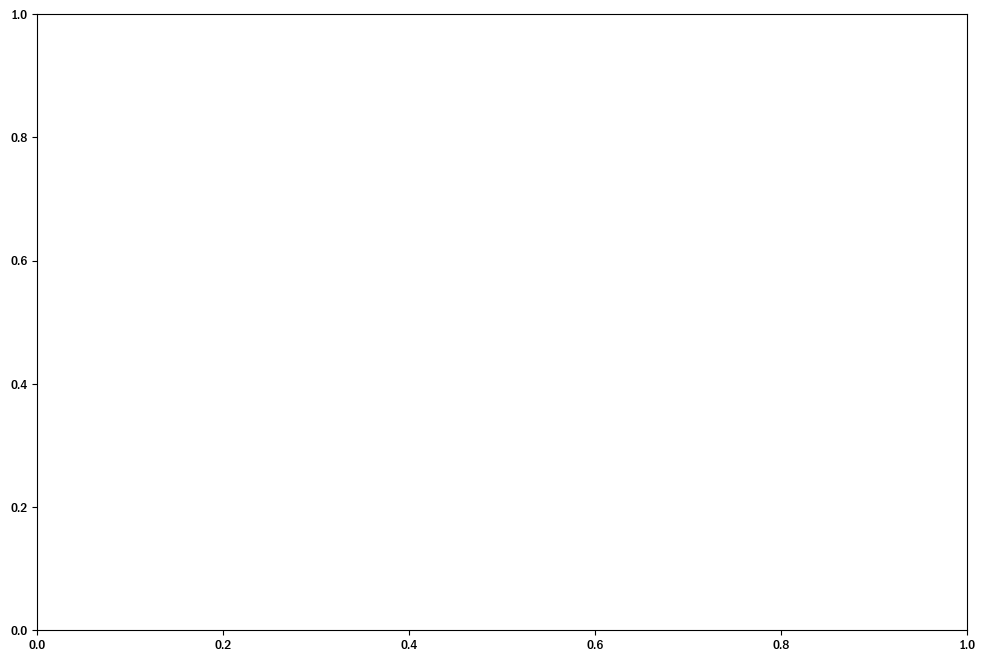

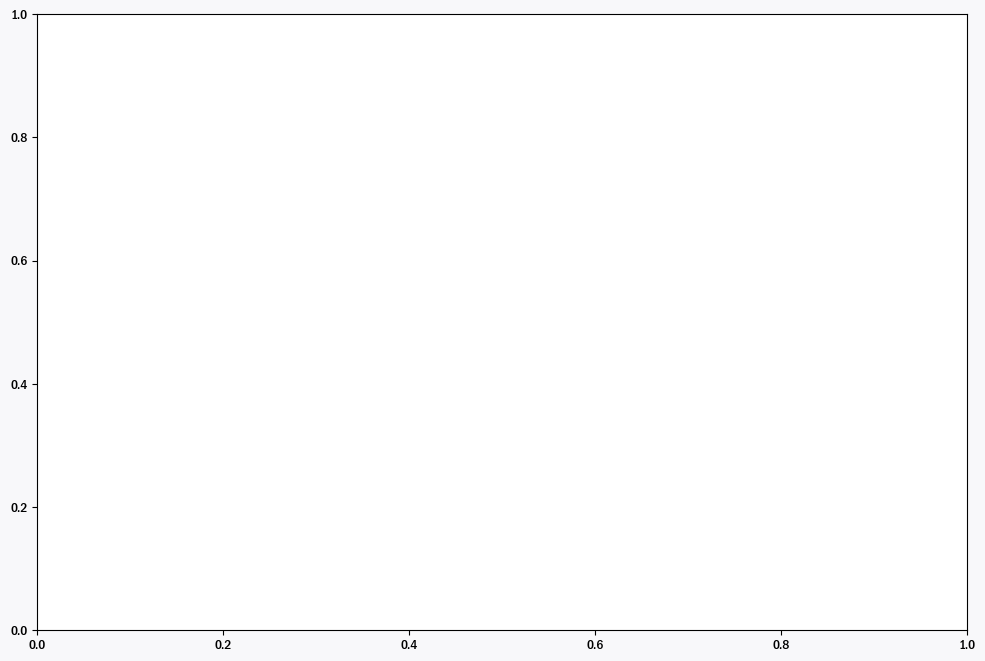

Available animation writers: ['pillow', 'ffmpeg', 'ffmpeg_file', 'html']
Saving animation...
Animation saved successfully!


In [32]:
# Function to prepare a background image that won't interfere with visualization
def prepare_background_image(image_path, target_width, target_height, blur_amount=3, brightness=1.3, saturation=0.7):
    """
    Prepare a background image by:
    1. Resizing to match the target dimensions
    2. Applying blur for subtlety
    3. Adjusting brightness and saturation
    
    Parameters:
    - image_path: Path to the background image
    - target_width, target_height: Desired dimensions
    - blur_amount: How much to blur (higher = more blur)
    - brightness: Brightness factor (>1 = brighter, <1 = darker)
    - saturation: Saturation factor (>1 = more saturated, <1 = less saturated)
    
    Returns:
    - Processed image as numpy array
    """
    try:
        # Open the image
        img = Image.open(image_path)
        
        # Convert to RGB mode if it's not already
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Resize to match target dimensions
        img = img.resize((target_width, target_height), Image.LANCZOS)
        
        # Apply blur for subtlety
        img = img.filter(ImageFilter.GaussianBlur(blur_amount))
        
        # Adjust brightness
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(brightness)
        
        # Adjust saturation
        enhancer = ImageEnhance.Color(img)
        img = enhancer.enhance(saturation)
        
        # Convert to numpy array for matplotlib
        return np.array(img)
    
    except Exception as e:
        print(f"Error processing background image: {e}")
        # Return a default subtle gradient background
        return create_gradient_background(target_width, target_height)

# Create a gradient background as fallback
def create_gradient_background(width, height, color1=(245, 245, 250), color2=(225, 225, 240)):
    """Create a subtle gradient background"""
    background = np.zeros((height, width, 3), dtype=np.uint8)
    for y in range(height):
        ratio = y / height
        for c in range(3):
            background[y, :, c] = color1[c] * (1 - ratio) + color2[c] * ratio
    return background

# Set up figure dimensions in inches and DPI for high resolution
fig_width, fig_height = 12, 8
dpi = 100

# Calculate pixel dimensions
pixel_width, pixel_height = int(fig_width * dpi), int(fig_height * dpi)

# Define the path to your background image or use the gradient
#foto_path = "your_background_image.jpg"  # Replace with your actual image path

# Try to load the background image, fall back to gradient if there's an issue
try:
    background_img = prepare_background_image(
        foto_path,
        pixel_width, 
        pixel_height,
        blur_amount=5,
        brightness=1.2,
        saturation=0.6
    )
except Exception as e:
    print(f"Falling back to gradient background: {e}")
    background_img = create_gradient_background(pixel_width, pixel_height)

# Create figure and axis
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)


def update(frame):
    ax.clear()
    df_fil = df_understat
    # Calculate which minute we're showing and how far along the growth we are
    current_minute = int(frame) + 1
    growth_fraction = frame - int(frame)  # Decimal part represents growth progress
    
    # Count shots per minute for all data
    shot_counts = df_fil.groupby('minute').size()
    minutes = list(range(0, int(max_minute) + 1))
    
    # Create arrays for the current state of the animation
    current_counts = []
    for minute in minutes:
        if minute < current_minute:
            # Previous minutes are fully grown
            count = shot_counts.get(minute, 0)
        elif minute == current_minute:
            # Current minute is growing
            count = shot_counts.get(minute, 0) * growth_fraction
        else:
            # Future minutes are not shown yet
            count = 0
        current_counts.append(count)
    
    # Calculate total shots
    if frame >= int(max_minute):
        total_shots = sum(shot_counts.get(min, 0) for min in range(0, max_minute + 1))
    else:
        total_shots = sum(shot_counts.get(min, 0) for min in range(0, current_minute))
        if growth_fraction > 0:
            total_shots += shot_counts.get(current_minute, 0) * growth_fraction
    
    # Add background image with careful alpha tuning
    ax.imshow(background_img, aspect='auto', 
              extent=[0, max_minute + 1, 0, shot_counts.max() + 1], 
              alpha=0.15,  # Very subtle background
              zorder=0)    # Ensure it's behind all other elements
    
    # Add a semi-transparent overlay to improve readability
    ax.add_patch(plt.Rectangle((0, 0), max_minute + 1, shot_counts.max() + 1, 
                              color='white', alpha=0.3, zorder=1))
    
    # Create stem plot with magenta lines and orange dots (higher zorder to be on top)
    markerline, stemlines, baseline = ax.stem(minutes, current_counts, 
                                             linefmt='m-', markerfmt='o', basefmt='k-')
    plt.setp(markerline, markersize=8, color='orange', zorder=3)  # Orange dots
    plt.setp(stemlines, linewidth=2, color='magenta', zorder=2)   # Magenta lines
    plt.setp(baseline, visible=False)  # Hide baseline for cleaner look
    
    # Set axis limits and labels
    ax.set_xlim(0, max_minute + 1)
    ax.set_ylim(0, shot_counts.max() + 1)
    ax.set_xlabel('Minutes', weight='bold', size=12)
    ax.set_ylabel('Number of Shots', weight='bold', size=12)
    
    # Style the grid for better visibility over background
    ax.grid(True, linestyle='--', alpha=0.6, color='gray', zorder=1)

    # Add title and information with enhanced visibility
    current_display_minute = current_minute if growth_fraction == 0 else f"{current_minute-1}→{current_minute}"
    ax.set_title(f'{club} Shot Count per Minute (Minute: {current_display_minute})', 
                weight='bold', size=15)
    
    # Add text with semi-transparent background for better readability
    text_box_props = dict(
        boxstyle='round,pad=0.5',
        facecolor='white',
        alpha=0.7,
        edgecolor='gray'
    )
    
    ax.text(max_minute * 0.7, ax.get_ylim()[1] * 0.9, 
            f'Total Shots: {int(total_shots)}', 
            weight='bold', size=15, 
            bbox=text_box_props,
            zorder=4)
    
    ax.text(max_minute * 0.7, ax.get_ylim()[1] * 0.1, 
            'Copyright: Enrique Adolfo López Magallón\nData: Understat.com.',
            bbox=text_box_props,
            zorder=4)
    
    # Ensure proper layout
    fig.tight_layout()
    
    # Force drawing update
    fig.canvas.draw()
    
    return fig, ax

# Create figure and axis with a complementary background color
fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi, 
                      facecolor='#f8f8fa')  # Very light blue-gray background

# Create animation with frames for growing each minute

# First define max_minute
max_minute = df_fil['minute'].max()
# Define frames_per_minute before using it
frames_per_minute = 20  # Set this to your desired value (typically same as fps)

# Then use it to create l_frames
all_frames = np.linspace(0, max_minute, int(max_minute) * frames_per_minute)

fps = 20  # Based on your writer fps setting
freeze_frames = int(7 * fps)  # 7 seconds worth of frames
last_frame = int(max_minute)  # The last frame value
freeze_extension = [last_frame] * freeze_frames
all_frames = np.append(all_frames, freeze_extension)  # Note: all_frames needs to be defined before this line
            
print(f"Creating animation with {len(all_frames)} frames")

# Try render animation with CUDA acceleration if available


ani = animation.FuncAnimation(
    fig, 
    update, 
    frames=all_frames,
    interval=50,  # Faster animation (50ms per frame)
    blit=False,
    repeat=False
)

# Show the animation
plt.show()

# The beginning part of your code remains the same

# Save the animation
available_writers = animation.writers.list()
print(f"Available animation writers: {available_writers}")

if 'ffmpeg' in available_writers:
    # Configure FFmpeg with more compatible settings
    ffmpeg_writer = animation.FFMpegWriter(  # Make sure to use animation.FFMpegWriter
        fps=20,  # Frames per second
        metadata=dict(artist='Enrique Adolfo Lopez Magallon'),
        bitrate=5000,  # Higher bitrate for better quality
        # More compatible encoding options
        codec='h264',  # Standard H.264 encoder instead of hardware-specific one
        extra_args=[
            '-preset', 'medium',  # Balanced preset
            '-crf', '23',  # Reasonable quality (lower = better quality)
            '-pix_fmt', 'yuv420p'  # Pixel format for better compatibility
            # Removed hardware acceleration options that were causing issues
        ]
    )

    # Save the animation with standard settings
    print("Saving animation...")
    ani.save(f'{club}_shots_animation_cuda.mp4', writer=ffmpeg_writer, dpi=300)
    print("Animation saved successfully!")
elif 'pillow' in available_writers:
    writer = animation.PillowWriter(fps=20)
    ani.save(f'{club}_shot_counts_stem_animation.gif', writer=writer, dpi=150)
else:
    print("No suitable writer found.")